In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url ="https://github.com/takitsuba/midoribon/blob/master/Chap9/input/chap9.csv"



In [4]:
#Git上からデータをインポート

import urllib.request
from io import StringIO

url ="https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap9/input/chap9.csv"

#csvを読み込む関数
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df

df = read_csv(url)

https://raw.githubusercontent.com/takitsuba/midoribon/master/Chap9/input/chap9.csv


In [5]:
df.head()

,Unnamed: 0,x,y
0,1,3.000000,5
1,2,3.210526,3
2,3,3.421053,6
3,4,3.631579,7
4,5,3.842105,7


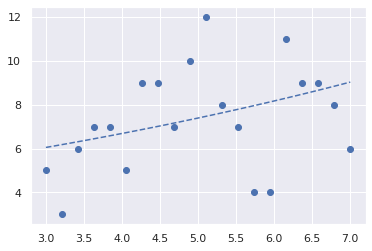

In [8]:
plt.plot(df["x"],df["y"],"bo") #散布図みたいになる
xx = np.linspace(3,7,100) #等差数列を作成
yy = np.exp(1.5+0.1*xx)
plt.plot(xx,yy,"--")

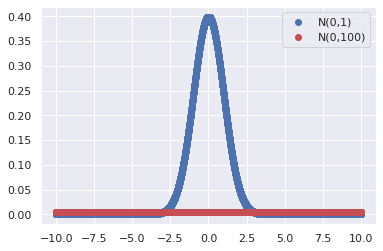

In [9]:
from scipy.stats import norm

n = np.linspace(-10,10,10000)

p_1=[]
p_100=[]
for i in range(len(n)):
    p_1.append(norm.pdf(x=n[i],loc=0,scale=1))
    p_100.append(norm.pdf(x=n[i],loc=0,scale=100))
    
plt.scatter(n,p_1,color="b",label="N(0,1)")
plt.scatter(n,p_100,color="r",label="N(0,100)")
plt.legend()

Stanコード

In [21]:
ps_data = {
    "N" : df.shape[0],
    "X" : df["x"],
    "y" : df["y"],
    "xmean" : df["x"].mean()
}

model = """
data {
  int<lower =1> N;
  real X[N];
  int<lower =0> y[N];
  real xmean;
}

parameters {
  real beta1;
  real beta2;
}

model {
  #無情報事前分布を指定（平均と標準偏差）
  beta1 ~ normal(0,100);
  beta2 ~ normal(0,100);

  #y_1,y_2にpoisson分布
  #lambda_iの指定には、対数リンク関数を使用
  for (i in 1:N){
    y[i] ~ poisson_log(beta1 + beta2*(X[i] - xmean));
  }
}
"""

**事後分布推定の準備**
<br>データの設定

In [12]:
X = df["x"]
y = df["y"]
N = X.shape[0]
xmean = X.mean()

# stanに辞書型でデータを引き渡す
stan_data = {"N": N, "X": X, "y": y,"xmean":xmean}

samplingの設定

In [25]:
import pystan as ps
import arviz as az

In [22]:
stmodel1 = ps.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b30c5196f3ae055bc7244135488008e7 NOW.


In [24]:
# 101個目から3個置きでサンプルを取得するチェインを３つ作る
n_iter = 1500
n_warmup = 100
n_chains = 3
n_thin = 3

# NUTSアルゴリズムを使ってサンプリングの実行
fit = stmodel1.sampling(
    data=ps_data,
    iter=n_iter,
    chains=n_chains,
    n_jobs=1,
    warmup=n_warmup,
    algorithm="NUTS",
    thin=n_thin,
    seed=0)

# サンプリング結果を表示
print(fit)

Inference for Stan model: anon_model_b30c5196f3ae055bc7244135488008e7.
3 chains, each with iter=1500; warmup=100; thin=3; 
post-warmup draws per chain=467, total post-warmup draws=1401.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   1.98  2.3e-3   0.09    1.8   1.92   1.98   2.03   2.15   1419    1.0
beta2   0.08  1.9e-3   0.07  -0.05   0.04   0.08   0.13   0.21   1307    1.0
lp__  143.93    0.03   1.06 141.09 143.53 144.28 144.68 144.95   1333    1.0

Samples were drawn using NUTS at Mon Oct  4 14:57:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80e7464250>,
      dtype=object)

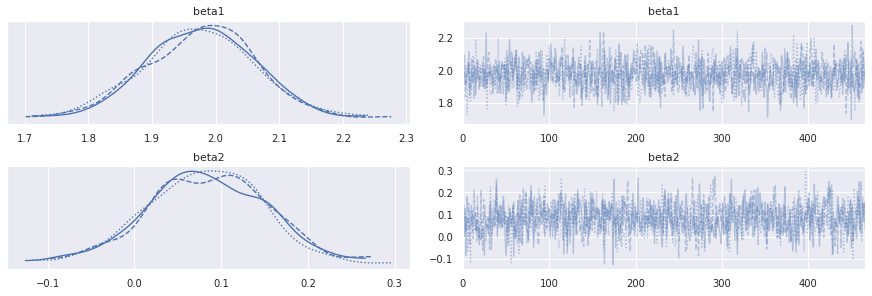

In [26]:
az.plot_trace(fit)

In [32]:
df_sample = pd.DataFrame()
df_sample["beta1"] = fit.extract()["beta1"] #正規表現で抽出
df_sample["beta2"] = fit.extract()["beta2"]


In [34]:
df_sample

,beta1,beta2
0,1.995329,0.065186
1,1.854320,0.213170
2,2.081195,0.111366
3,2.123546,0.052540
4,2.067474,-0.026108
...,...,...
1396,1.998228,0.099031
1397,1.988034,0.267261
1398,1.986406,0.124885
1399,2.095658,0.001152


(3.0, 12.0)

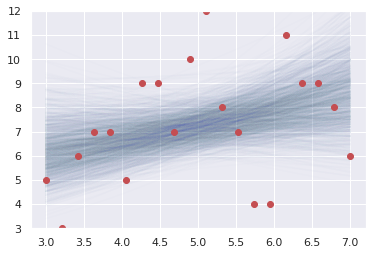

In [38]:
xx = np.linspace(3,7,100)

for i in range(df_sample.shape[0]):
  beta1 = df_sample["beta1"][i]
  beta2 = df_sample["beta2"][i]

  yy = np.exp(beta1 + beta2*(xx-xmean))

  plt.plot(xx,yy,color="b",alpha=0.01)

plt.plot(df["x"],df["y"],"ro")
plt.ylim(3,12)

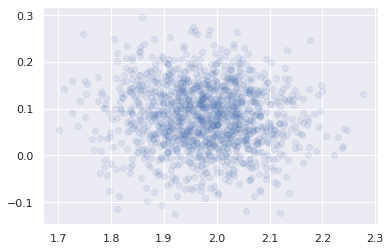

In [39]:
plt.scatter(df_sample.beta1,df_sample.beta2,alpha=0.1)